# COMP0051 Coursework 1

Shijun Luo 22183515

## Introduction

In this report, I downloaded the data from the internet and clean the data. After that, I construct 3 different algorithm trading strategies, and compare them with the buy and hold strategy. At last I analysed some common performance indicators of those strategies. 

The resources I used to download data are 'https://finance.yahoo.com/quote/SPY/' and 'https://fred.stlouisfed.org/series/EFFR'.

The strategies I have used are:

0: Buy and Hold

1: Trend Following

2: Mean Reversion

3: Epsilon Level - Mean Reversion

The performance indicators I have analysed are: Sharpe Ratio (SR), Sortino Ratio, Maximum
Drawdown and the Calmar ratio.

## Methodology

First of all, we have to get the data from internet.
### 1. Time Series Prep


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import os
from tabulate import tabulate
import yfinance as yf
import datetime
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# 1. Time Series Prep

In [43]:
# Read effective federal funds rate data
effr_file_path = 'Search.csv'
effr_df = pd.read_csv(effr_file_path)
# Convert 'Effective Date' column to datetime and set it as index
effr_df['Effective Date'] = pd.to_datetime(effr_df['Effective Date'])
effr_df.set_index('Effective Date', inplace=True)
# Convert 'Rate (%)' to decimal and calculate daily rate
effr_df['Rate'] = effr_df['Rate (%)'] / 100
effr_df['Daily Rate'] = effr_df['Rate'] / 252

# Read SPDR (iShares 1-3 Year Treasury Bond ETF) data
start_date = datetime.datetime(2014, 1, 1)
end_date = datetime.datetime(2020, 1, 1)  # will not include this exactly day!
spdr_df = yf.download('SPY', start_date, end_date)

# Convert 'Date' column to datetime and set it as index
spdr_df.index = pd.to_datetime(spdr_df.index)

# Calculate daily returns
spdr_df['Daily Return'] = spdr_df['Adj Close'].pct_change()


[*********************100%***********************]  1 of 1 completed


After trying to print the length and the content of the data, I found out that there are some different days and gaps in the two data, so they can't be merged simply. So I removed the different days and the missing days. Then I use them to calculate the daily excess return per unit of SPDR, and the SPDR return time series, and save them as lists. I use log return because it is more common and has better properties. Then plot them.

In [44]:
# Join SPDR and effective federal funds rate data
aligned_data = spdr_df.join(effr_df['Daily Rate'], how='inner')
# Calculate excess returns: SPDR return - EFFR daily rate
aligned_data['Excess Return'] = aligned_data['Daily Return'] - aligned_data['Daily Rate']
# Drop rows with NaN values
aligned_data = aligned_data.dropna()

# Print excess returns
print(aligned_data['Excess Return'].head())


2014-01-03   -0.000168
2014-01-06   -0.002901
2014-01-07    0.006139
2014-01-08    0.000215
2014-01-09    0.000651
Name: Excess Return, dtype: float64


**(b) Plot the SPDR return time series, the EFFR, and the excess return per unit of SPDR, starting from t = 0 corresponding to 1 Jan 2014.**

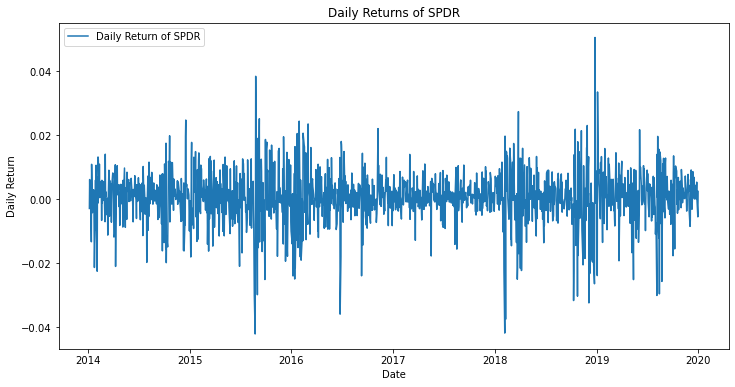

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(aligned_data['Adj Close'].pct_change(), label='Daily Return of SPDR')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Daily Returns of SPDR')
plt.legend()
plt.show()

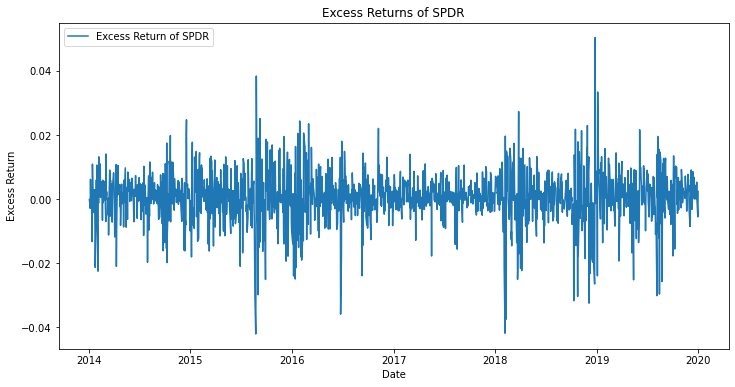

In [46]:
#excess return plot
plt.figure(figsize=(12, 6))
plt.plot(aligned_data['Excess Return'], label='Excess Return of SPDR')
plt.xlabel('Date')
plt.ylabel('Excess Return')
plt.title('Excess Returns of SPDR')
plt.legend()
plt.show()

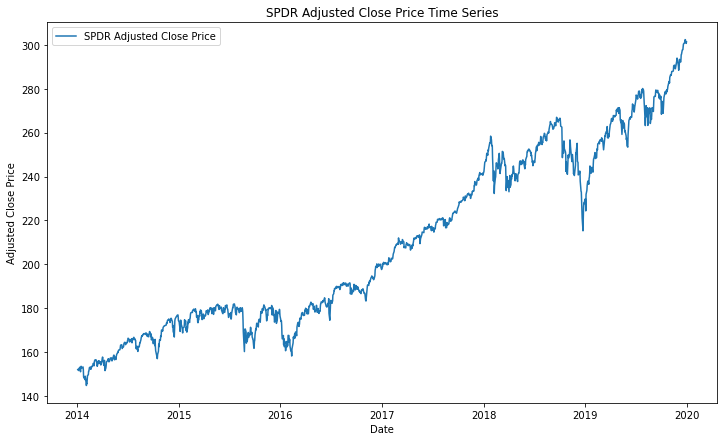

In [47]:
plt.figure(figsize=(12, 7))
plt.plot(aligned_data['Adj Close'], label='SPDR Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('SPDR Adjusted Close Price Time Series')
plt.legend()
plt.show()

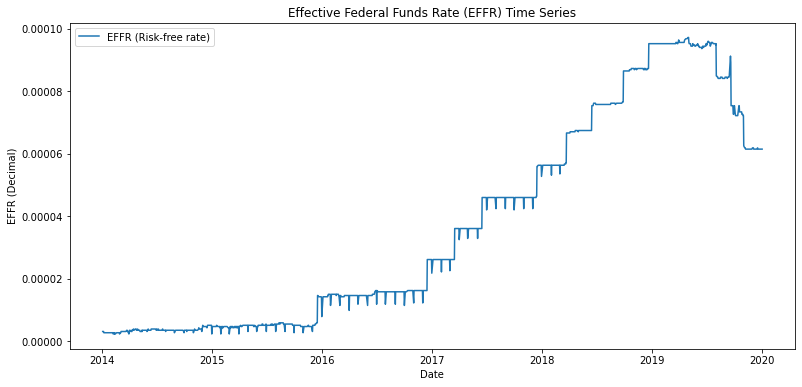

In [48]:
plt.figure(figsize=(13, 6))
plt.plot(aligned_data['Daily Rate'], label='EFFR (Risk-free rate)')
plt.xlabel('Date')
plt.ylabel('EFFR (Decimal)')
plt.title('Effective Federal Funds Rate (EFFR) Time Series')
plt.legend()
plt.show()

I find that the excess return time series looks have good properties(like white noise): zero mean, constant variance, and is uncorrelated in time. But I noticed that the length among these data are different(because the were differentiated) so I can only use the short one in the later process.

# 2. Trading Strategies
1. **Trend Following Strategy**:
   - This strategy involves using a single moving average to determine the trend direction and enter positions accordingly.
   - Formula:
     - Buy Signal: When the price crosses above the moving average (e.g., 50-day moving average).
     - Sell Signal: When the price crosses below the moving average.
   - Details:
     - Buy Signal: $P_t > MA_t$ where $P_t$ is the current price and $MA_t$ is the moving average at time $t$.
     - Sell Signal: $P_t < MA_t$.
     - Moving Average Calculation: $MA_t = \frac{{P_{t-1} + P_{t-2} + ... + P_{t-n}}}{{n}}$, where $n$ is the period of the moving average.


2. **Mean Reversion Strategy**:
   - This strategy involves buying assets when prices are below their historical average and selling when prices are above the average.
   - Formula:
     - Buy Signal: When the price is below the moving average (e.g., 50-day SMA).
     - Sell Signal: When the price is above the moving average.
   - Details:
     - Buy Signal: $P_t < MA_t$.
     - Sell Signal: $P_t > MA_t$.
     - Moving Average Calculation: Same as in the trend following strategy.


3. **Autoregressive Strategy**:
   - This strategy involves using a autoregressive model to predict future price movements based on past prices.
   - Formula:
     - $P_{t+1} = a_0 + a_1 * P_t + \varepsilon_{t+1}$, where $P_t$ is the price at time $t$, $a_0$ and $a_1$ are coefficients, and $\varepsilon_{t+1}$ is the error term.
     - Buy Signal: Predicted future price $P_{t+1}$ is higher than the current price $P_t$.
     - Sell Signal: Predicted future price $P_{t+1}$ is lower than the current price $P_t$.
   - Details:
     - Fit an autoregressive model to historical price data to estimate coefficients $a_0$ and $a_1$.
     - Use the model to predict future prices $P_{t+1}$.
     - Buy Signal: $P_{t+1} > P_t$.
     - Sell Signal: $P_{t+1} < P_t$.


In [49]:
class AlgorithmTrading:
    def __init__(self, data, V0=200000, L=10, train_ratio=0.7, ma_window=50, lag = 1):
        self.date = data.index
        self.price = data['Adj Close']
        self.daily_return = data['Daily Return']
        self.risk_free_rate = data['Daily Rate']
        self.V0 = V0
        self.L = L
        self.train_ratio = train_ratio
        self.ma_window = ma_window
        self.volatility = self.price.rolling(window=self.ma_window).std()
        self.lag = lag
        self.train_data = None
        self.test_data = None
        self.performance_metrics = {}
        self.train_positions = None
        self.test_positions = None
        self.train_cash = None
        self.test_cash = None

    def split_data(self):
        split_index = int(self.train_ratio * len(self.price))
        self.train_data = self.price[:split_index]
        self.test_data = self.price[split_index:]

    def trend_following_strategy(self, data):
        self.split_data()

        ma = data.rolling(window=self.ma_window).mean()
        buy_signal = data > ma
        sell_signal = data < ma

        positions = pd.Series(index=self.date)
        positions[0] = 0
        cash = pd.Series(index=self.date)
        cash[0] = self.V0
        for i in range(len(data) - 1):
            if buy_signal[i]:
                positions[i+1] = cash[i] / data[i] + positions[i]
                cash[i+1] = 0
            elif sell_signal[i]:
                positions[i+1] = 0
                cash[i+1] = cash[i] + data[i] * positions[i]
            else:
                positions[i+1] = positions[i]
                cash[i+1] = cash[i]
        return positions, cash

    def mean_reversion_strategy(self, data):
        self.split_data()

        ma = data.rolling(window=self.ma_window).mean()
        buy_signal = data < ma
        sell_signal = data > ma
        
        positions = pd.Series(index=self.date)
        positions[0] = 0
        cash = pd.Series(index=self.date)
        cash[0] = self.V0
        for i in range(len(data) - 1):
            if buy_signal[i]:
                positions[i+1] = cash[i] / data[i] + positions[i]
                cash[i+1] = 0
            elif sell_signal[i]:
                positions[i+1] = 0
                cash[i+1] = cash[i] + data[i] * positions[i]
            else:
                positions[i+1] = positions[i]
                cash[i+1] = cash[i]
        return positions, cash

    def ar_strategy(self, data):
        self.split_data()

        # Fit autoregressive model
        model = AutoReg(data.tolist(), lags=self.lag)
        ar_model = model.fit()

        # Predict prices using autoregressive model
        predicted_prices = pd.Series(ar_model.predict(), index = self.date)

        # Calculate positions based on predicted prices
        positions = pd.Series(index=self.date, dtype = float)
        positions[0] = 0
        cash = pd.Series(index=self.date, dtype = float)
        cash[0] = self.V0

        for i in range(len(data) - 1):
            if i < self.lag or predicted_prices[i+1] == predicted_prices[i]:
                positions[i+1] = positions[i]
                cash[i+1] = cash[i]
            elif predicted_prices[i+1] > predicted_prices[i]:  # Buy if price is predicted to increase
                positions[i+1] = cash[i] / data[i] + positions[i]
                cash[i+1] = 0
            else:  # Sell if price is predicted to decrease
                positions[i+1] = 0
                cash[i+1] = cash[i] + data[i] * positions[i]
        return positions, cash

    def postprocessing(self):
        self.value = self.cash + self.price * self.positions * self.L
        self.pnlQ3 = self.value.diff()
        self.returns = self.value.pct_change()
        
        # Calculate performance metrics
        self.train_size = int(len(self.returns) * self.train_ratio)
        self.train_returns = self.returns[:self.train_size]
        self.test_returns = self.returns[self.train_size:]

    def plot_pnl(self):
        self.pnl_position = (self.price.diff() - self.risk_free_rate) * self.positions * self.price * self.L
        self.pnl_cash = self.cash * self.risk_free_rate
        self.pnl_total = self.pnl_position + self.pnl_cash

        # Plot dV_value
        plt.plot(self.date, self.pnl_position, label='Trading PnL', color='blue')
        plt.plot(self.date, self.pnl_position.cumsum(), label='Cumulative Trading PnL', linestyle='--', color='lightblue')

        # Plot dV_cap
        plt.plot(self.date, self.pnl_cash, label='Capital Account PnL', color='green')
        plt.plot(self.date, self.pnl_cash.cumsum(), label='Cumulative Capital Account PnL', linestyle='--', color='lightgreen')

        # Plot dV_total
        plt.plot(self.date, self.pnl_total, label='Total PnL', color='red')
        plt.plot(self.date, self.pnl_total.cumsum(), label='Cumulative Total PnL', linestyle='--', color='pink')

        plt.xlabel('Date')
        plt.ylabel('PnL')
        plt.title(f"PnL Series of {self.strategy} Strategy:")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_pnl_separate(self):
        self.pnl_position = (self.price.diff() - self.risk_free_rate) * self.positions * self.price * self.L
        self.pnl_cash = self.cash * self.risk_free_rate
        self.pnl_total = self.pnl_position + self.pnl_cash

        # Plotting Trading PnL
        plt.figure(figsize=(12, 4))
        plt.plot(self.date, self.pnl_position, label='Trading PnL', color='blue')
        plt.plot(self.date, self.pnl_position.cumsum(), label='Cumulative Trading PnL', linestyle='--', color='lightblue')
        plt.xlabel('Date')
        plt.ylabel('PnL')
        plt.title(f"Trading PnL of {self.strategy} Strategy")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plotting Capital Account
        plt.figure(figsize=(12, 4))
        plt.plot(self.date, self.pnl_cash, label='Capital Account PnL', color='green')
        plt.plot(self.date, self.pnl_cash.cumsum(), label='Cumulative Capital Account PnL', linestyle='--', color='lightgreen')
        plt.xlabel('Date')
        plt.ylabel('PnL')
        plt.title(f"Capital Account of {self.strategy} Strategy")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plotting Total PnL
        plt.figure(figsize=(12, 4))
        plt.plot(self.date, self.pnl_total, label='Total PnL', color='red')
        plt.plot(self.date, self.pnl_total.cumsum(), label='Cumulative Total PnL', linestyle='--', color='pink')
        plt.xlabel('Date')
        plt.ylabel('PnL')
        plt.title(f"Total PnL of {self.strategy} Strategy")
        plt.legend()
        plt.grid(True)
        plt.show()

    def calculate_performance_metrics(self):
        # Metrics for train set
        self.train_metrics = self.calculate_metrics(self.train_returns)
        # Metrics for test set
        self.test_metrics = self.calculate_metrics(self.test_returns)

        # Format and print metrics
        print(f"Performance Metrics of {self.strategy} Strategy:")
        print(tabulate([["Train"] + self.train_metrics,
                        ["Test"] + self.test_metrics],
                       headers=["Dataset", "Sharpe Ratio", "Sortino Ratio", "Max Drawdown", "Max Drawdown Ratio", "Calmar Ratio"]))

    def calculate_metrics(self, returns):
        # Calculate performance metrics
        sharpe = self.sharpe_ratio(returns)
        sortino = self.sortino_ratio(returns)
        max_drawdown = self.max_drawdown(returns)
        max_drawdown_ratio = self.max_drawdown_ratio(returns)
        calmar = self.calmar_ratio(returns)
        return round(pd.Series([sharpe, sortino, max_drawdown, max_drawdown_ratio, calmar]), 2).tolist()

    def sharpe_ratio(self, returns):
        # Calculate Sharpe Ratio
        sharpe_ratio = np.sqrt(252) * (self.returns.mean() - self.risk_free_rate.mean()) / returns.std()
        return sharpe_ratio

    def sortino_ratio(self, returns):
        # Calculate Sortino Ratio
        downside_returns = returns[returns < 0]
        sortino_ratio = np.sqrt(252) * (self.returns.mean() - self.risk_free_rate.mean()) / downside_returns.std()
        return sortino_ratio

    def max_drawdown(self, returns):
        # Calculate Maximum Drawdown
        cum_returns = (1 + returns).cumprod()
        return -(cum_returns - cum_returns.cummax()).min()

    def max_drawdown_ratio(self, returns):
        # Calculate Maximum Drawdown Ratio
        cum_returns = (1 + returns).cumprod()
        return -(cum_returns / cum_returns.cummax() - 1).min()

    def calmar_ratio(self, returns):
        # Calculate Calmar Ratio
        cum_returns = (1 + returns).cumprod()
        calmar_ratio = cum_returns.mean() / self.max_drawdown(returns)
        return calmar_ratio

    def plot_position_with_bounds(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.date, self.price * self.positions * self.L, label='Position', color='blue')
        plt.plot(self.date, self.value, label='Upper Bound', linestyle='--', color='red')
        plt.plot(self.date, -self.value, label='Lower Bound', linestyle='--', color='green')
        plt.title(f"Position with Upper and Lower Bounds of {self.strategy} Strategy:")
        plt.xlabel('Date')
        plt.ylabel('Position')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_ma_turnover_and_volatility(self):
        # Calculate turnover values and turnover units
        turnover_values = abs((self.positions * self.price).diff()).cumsum() * self.L
        ma_turnover_values = turnover_values.rolling(window=self.ma_window).mean()
        turnover_units = abs(self.positions.diff()).cumsum() * self.L
        ma_turnover_units = turnover_units.rolling(window=self.ma_window).mean()

        # Plotting
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Plot turnover values and moving average turnover values
        ax1.plot(self.date, turnover_values, label='Turnover Values', color='blue')
        ax1.plot(self.date, ma_turnover_values, label=f'MA Turnover Values (Window={self.ma_window})', linestyle='--', color='green')
        ax1.set_ylabel('Turnover Values')
        ax1.tick_params(axis='y', labelcolor='blue')

        # Create a secondary y-axis for turnover units
        ax2 = ax1.twinx()
        ax2.plot(self.date, turnover_units, label='Turnover Units', color='red')
        ax2.plot(self.date, ma_turnover_units, label=f'MA Turnover Units (Window={self.ma_window})', linestyle='--', color='orange')
        ax2.set_ylabel('Turnover Units')
        ax2.tick_params(axis='y', labelcolor='red')

        # Create a third y-axis for volatility
        ax3 = ax1.twinx()
        ax3.plot(self.date, self.volatility, label=f'MA Volatility (Window={self.ma_window})', linestyle='--', color='purple')
        ax3.set_ylabel('Volatility')
        ax3.tick_params(axis='y', labelcolor='purple')

        # Adjust positions of the third y-axis
        ax3.spines['right'].set_position(('outward', 60))
        ax3.yaxis.label.set_color('purple')

        # Set legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        lines3, labels3 = ax3.get_legend_handles_labels()
        ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3)

        # Other plot settings
        plt.title(f"Turnover and Volatility of {self.strategy} Strategy:")
        plt.xlabel('Date')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_ma_turnover_and_volatility_separate(self):
        self.plot_turnover_values_vs_volatility()
        self.plot_turnover_units_vs_volatility()

    def plot_turnover_values_vs_volatility(self):
        # Calculate turnover values and turnover units
        turnover_values = abs((self.positions * self.price).diff()).cumsum() * self.L
        ma_turnover_values = turnover_values.rolling(window=self.ma_window).mean()

        # Plotting
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Plot turnover values and volatility
        ax1.plot(self.date, turnover_values, label='Turnover Values', color='blue')
        ax1.plot(self.date, ma_turnover_values, label=f'MA Turnover Values (Window={self.ma_window})', linestyle='--', color='green')
        ax1.set_ylabel('Turnover Values', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        # Create a secondary y-axis for volatility
        ax2 = ax1.twinx()
        ax2.plot(self.date, self.volatility, label=f'MA Volatility (Window={self.ma_window})', linestyle='--', color='red')
        ax2.set_ylabel('Volatility', color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        # Set legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2)

        # Other plot settings
        fig.tight_layout()
        plt.title(f"Turnover Values vs Volatility of {self.strategy} Strategy:")
        plt.xlabel('Date')
        plt.grid(True)
        plt.show()

    def plot_turnover_units_vs_volatility(self):
        # Calculate turnover units
        turnover_units = abs(self.positions.diff()).cumsum() * self.L
        ma_turnover_units = turnover_units.rolling(window=self.ma_window).mean()
        
        # Plotting
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Plot turnover units and volatility
        ax1.plot(self.date, turnover_units, label='Turnover Units', color='red')
        ax1.plot(self.date, ma_turnover_units, label=f'MA Turnover Units (Window={self.ma_window})', linestyle='--', color='orange')
        ax1.set_ylabel('Turnover Units', color='green')
        ax1.tick_params(axis='y', labelcolor='green')

        # Create a secondary y-axis for volatility
        ax2 = ax1.twinx()
        ax2.plot(self.date, self.volatility, label=f'MA Volatility (Window={self.ma_window})', linestyle='--', color='purple')
        ax2.set_ylabel('Volatility', color='purple')
        ax2.tick_params(axis='y', labelcolor='purple')

        # Set legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2)

        # Other plot settings
        fig.tight_layout()
        plt.title(f"Turnover Units vs Volatility of {self.strategy} Strategy:")
        plt.xlabel('Date')
        plt.grid(True)
        plt.show()

    def plot_rolling_sharpe_ratio(self):
        # Calculate rolling Sharpe ratio
        rolling_sharpe = self.returns.rolling(window=self.ma_window).mean() / self.returns.rolling(window=self.ma_window).std()

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(self.date[:self.train_size], rolling_sharpe[:self.train_size], label='Train Set', color='blue')
        plt.plot(self.date[self.train_size:], rolling_sharpe[self.train_size:], label='Test Set', color='orange')
        plt.title(f"Rolling Sharpe Ratio of {self.strategy} Strategy:")
        plt.xlabel('Date')
        plt.ylabel('Sharpe Ratio')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_drawdown_and_volatility(self):
        # Calculate 90-day volatility
        volatility_90 = self.price.rolling(window=90).std()
        # Calculate Drawdown
        self.drawdown = self.value - self.value.cummax()
        self.drawdown_ratio = self.drawdown / self.value.cummax()
        # Calculate Maximum Drawdown in train and test
        drawdown_train = self.drawdown[:self.train_size].min()
        drawdown_test = self.drawdown[self.train_size:].min()
        drawdown_train_index = self.date[np.argmin(self.drawdown[:self.train_size])]
        drawdown_test_index = self.date[np.argmin(self.drawdown[self.train_size:]) + self.train_size]

        # Plot Drawdown chart and 90-day volatility
        # Drawdown
        fig, ax1 = plt.subplots(figsize=(10, 6))
        ax1.plot(self.value, label='Value Account', color='red')
        ax1.plot(self.drawdown, label='Drawdown', color='orange')
        ax1.plot(drawdown_train_index, drawdown_train, label='Max Drawdown in Train Set', marker="o", markeredgecolor="coral", markerfacecolor="cyan")
        ax1.plot(drawdown_test_index, drawdown_test, label='Max Drawdown in Test Set', marker="o", markeredgecolor="magenta", markerfacecolor="cyan")
        ax1.plot(self.date, np.zeros(len(self.date)), label='Zero Line', linestyle='--')
        ax1.grid(False)
        ax1.set_ylabel('Drawdown')
        ax1.legend(loc="upper left")
        # 90-day volatility
        ax2 = ax1.twinx()
        ax2.plot(self.date, volatility_90, label='Asset Price 90-day Volatility', color='tab:blue')
        ax2.grid(False)
        ax2.set_ylabel('Rolling Volatility')
        ax2.legend(bbox_to_anchor=(0, 0.59), loc="lower left")

        fig.tight_layout()
        plt.title(f"Maximum Drawdown and 90-day Volatility of {self.strategy} Strategy:")
        plt.show()

    # Q2.a
    def run(self, strategy):
        # Main method to run the algorithm trading simulation with specified strategy
        self.split_data()
        self.strategy = strategy
        if strategy == 'Trend Following':
            self.positions, self.cash = self.trend_following_strategy(self.price)
        elif strategy == 'Mean Reversion':
            self.positions, self.cash = self.mean_reversion_strategy(self.price)
        elif strategy == 'AR':
            self.positions, self.cash = self.ar_strategy(self.price)
        else:
            raise ValueError("Invalid strategy specified.")
        self.postprocessing()

        # Q2.b Plot positions with bounds and volatility
        self.plot_position_with_bounds()

        # Q2.b Plot MA of the turnover and volatility
        #self.plot_ma_turnover_and_volatility()
        self.plot_ma_turnover_and_volatility_separate()

        # Q2.c Calculate PnL and plot
        #self.plot_pnl()
        self.plot_pnl_separate()

        # Q3.a Calculate Performance Metrics
        self.calculate_performance_metrics()

        # Q3.b Plot rolling sharpe ratio
        self.plot_rolling_sharpe_ratio()

        # Q3.c Plot drawdown and volatility
        self.plot_drawdown_and_volatility()
        
algo_trading = AlgorithmTrading(aligned_data, lag = 50)


**Backtest**:

1. **Sharpe Ratio**:
   - The Sharpe Ratio measures the risk-adjusted return of an investment or trading strategy.
   - **Formula**:
     $$ Sharpe\ Ratio = \frac{{R_p - R_f}}{{\sigma_p}} $$
     Where:
     - $ R_p $ = Average return of the portfolio/strategy.
     - $ R_f $ = Risk-free rate of return (typically a treasury bill rate).
     - $ \sigma_p $ = Standard deviation of the portfolio/strategy's returns.

2. **Sortino Ratio**:
   - The Sortino Ratio is similar to the Sharpe Ratio but only considers downside risk.
   - **Formula**:
     $$ Sortino\ Ratio = \frac{{R_p - R_f}}{{\sigma_{down}}} $$
     Where:
     - $ R_p $ = Average return of the portfolio/strategy.
     - $ R_f $ = Risk-free rate of return (typically a treasury bill rate).
     - $ \sigma_{down} $ = Standard deviation of negative returns (downside deviation).

3. **Maximum Drawdown**:
   - Maximum Drawdown measures the largest peak-to-trough decline of a portfolio/strategy.
   - **Formula**:
     $$ Maximum\ Drawdown = \max_{i,j} \left( \frac{{P_i - P_j}}{{P_i}} \right) $$
     Where:
     - $ P_i $ = Portfolio/strategy value at time $ i $.
     - $ P_j $ = Lowest portfolio/strategy value between $ i $ and $ j $.

4. **Maximum Drawdown Ratio**:
   - The Maximum Drawdown Ratio measures the relationship between maximum drawdown and average returns.
   - **Formula**:
     $$ Maximum\ Drawdown\ Ratio = \frac{{R_p}}{{\text{Maximum Drawdown}}} $$
     Where:
     - $ R_p $ = Average return of the portfolio/strategy.

5. **Calmar Ratio**:
   - The Calmar Ratio is a risk-adjusted measure calculated as the ratio of average annualized returns to maximum drawdown.
   - **Formula**:
     $$ Calmar\ Ratio = \frac{{R_p}}{{\text{Maximum Drawdown}}} $$
     Where:
     - $ R_p $ = Average annualized return of the portfolio/strategy.


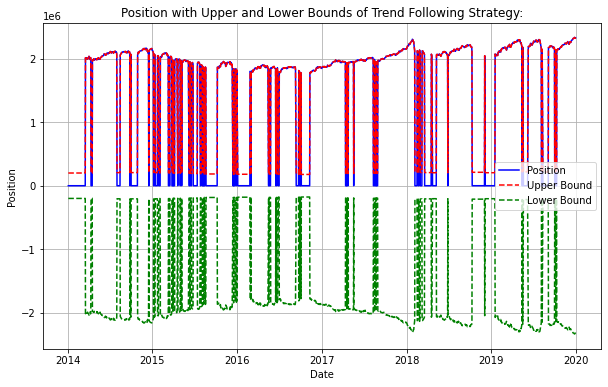

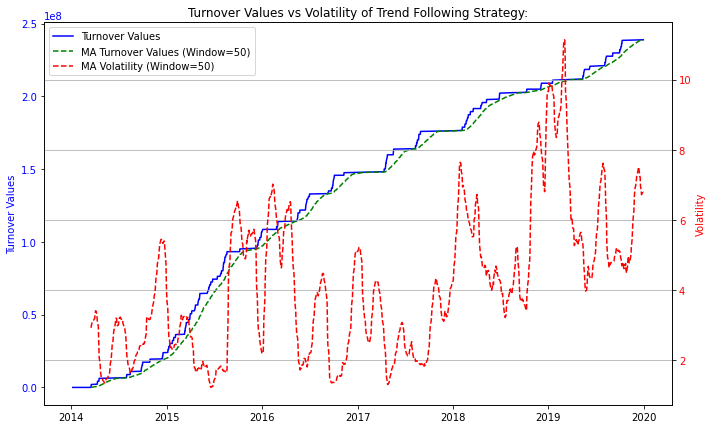

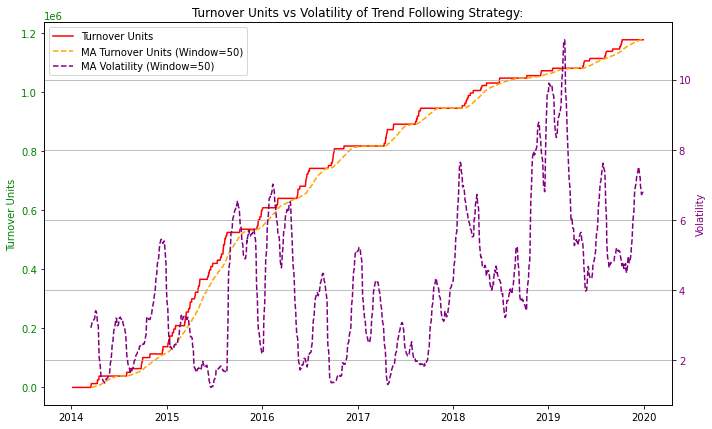

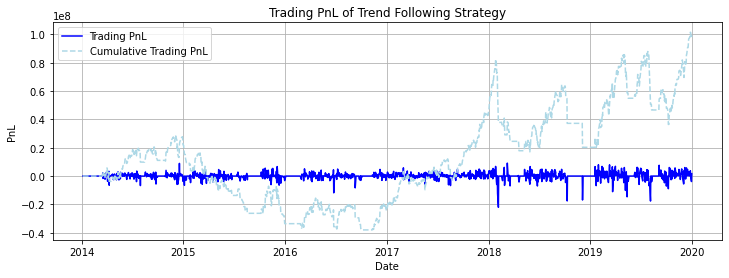

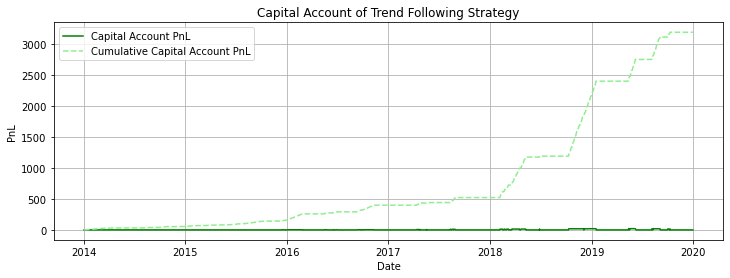

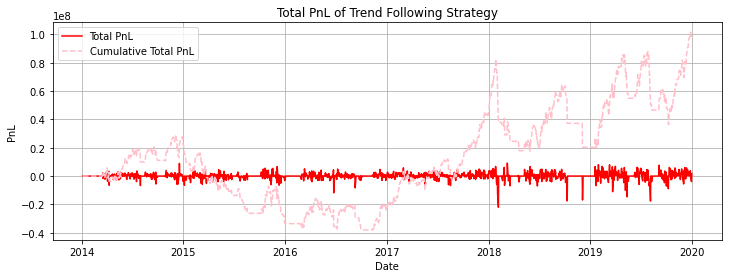

Performance Metrics of Trend Following Strategy:
Dataset      Sharpe Ratio    Sortino Ratio    Max Drawdown    Max Drawdown Ratio    Calmar Ratio
---------  --------------  ---------------  --------------  --------------------  --------------
Train                2.67            17.01           10.48                  0.92            0.7
Test                 3.62            21.14            0.99                  0.91            0.75


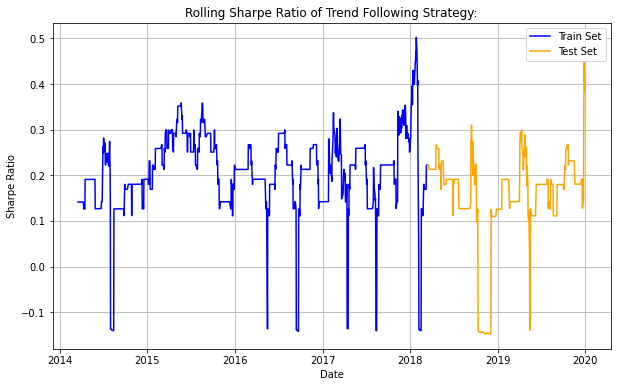

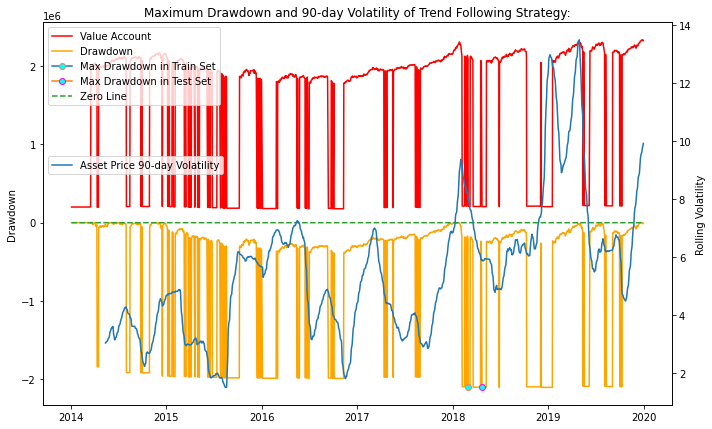

In [50]:
strategy_to_run = 'Trend Following'
algo_trading.run(strategy_to_run)


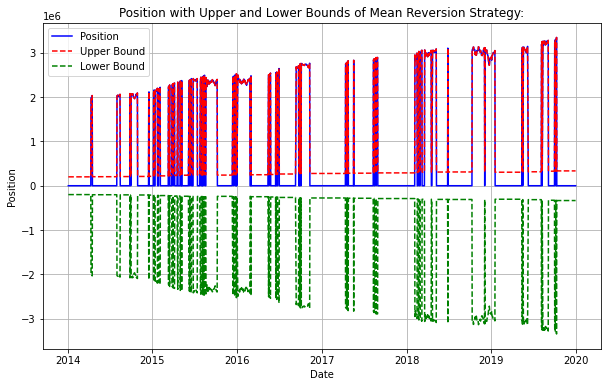

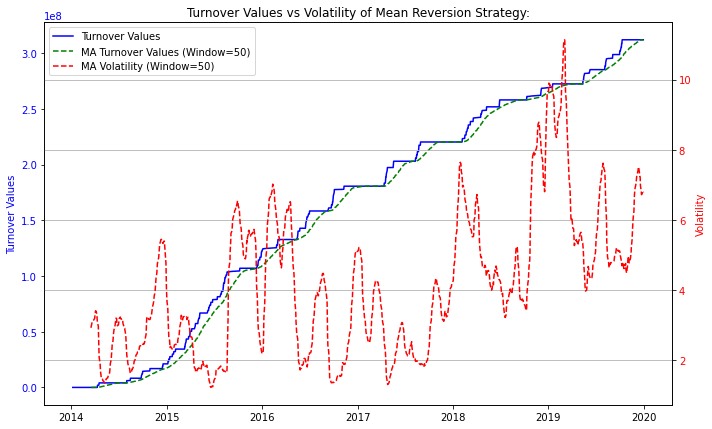

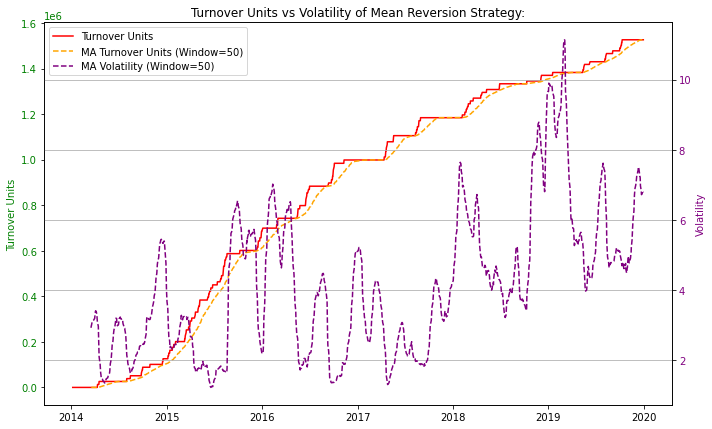

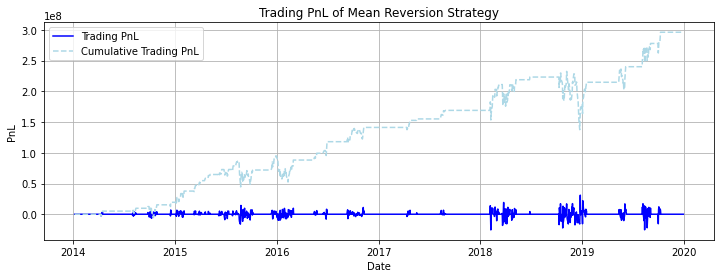

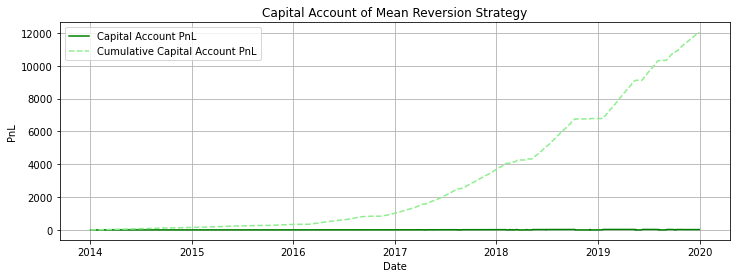

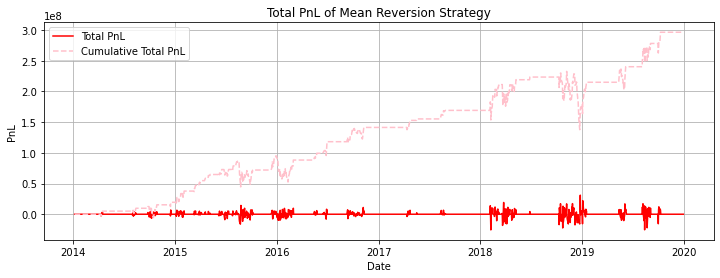

Performance Metrics of Mean Reversion Strategy:
Dataset      Sharpe Ratio    Sortino Ratio    Max Drawdown    Max Drawdown Ratio    Calmar Ratio
---------  --------------  ---------------  --------------  --------------------  --------------
Train                2.65            11.45           13.75                   0.9            0.28
Test                 3.56            14.93            9.85                   0.9            0.39


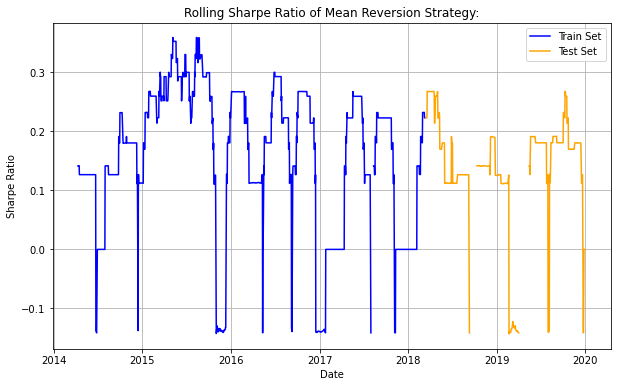

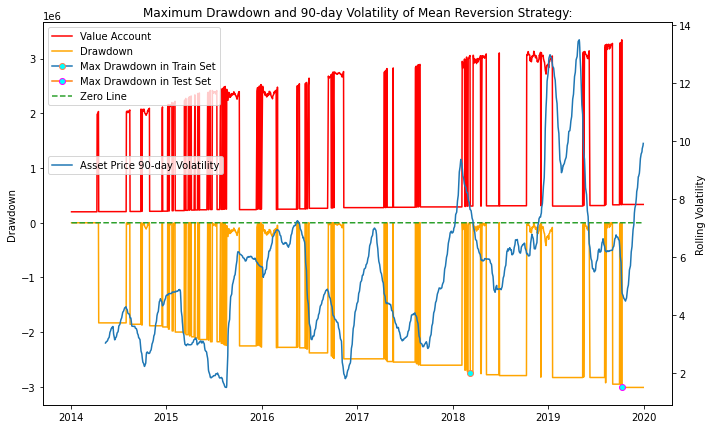

In [51]:
strategy_to_run = 'Mean Reversion'
algo_trading.run(strategy_to_run)


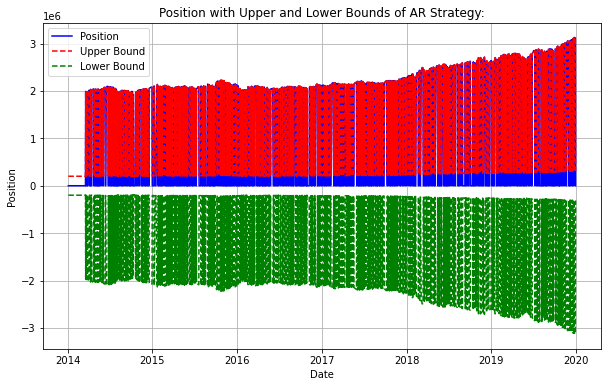

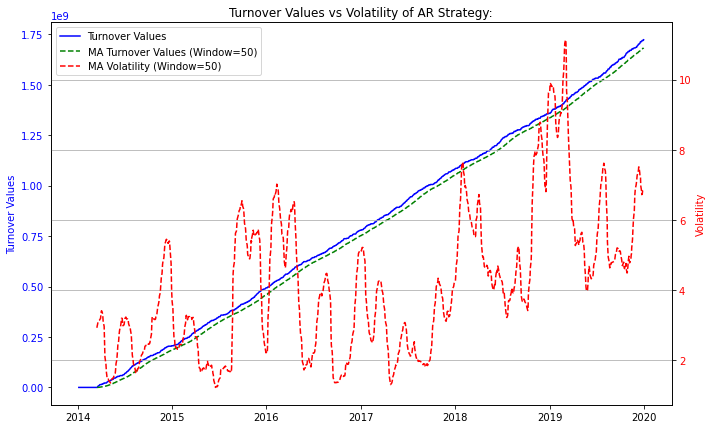

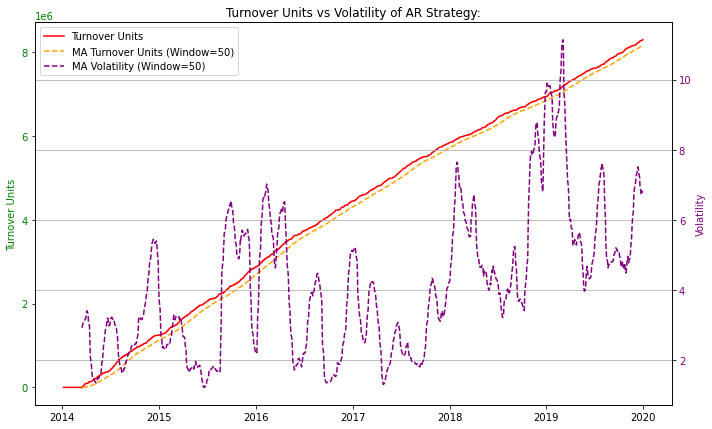

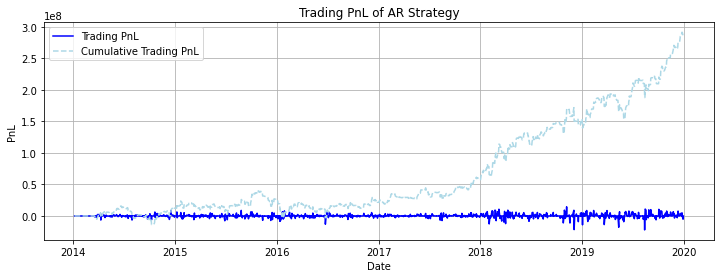

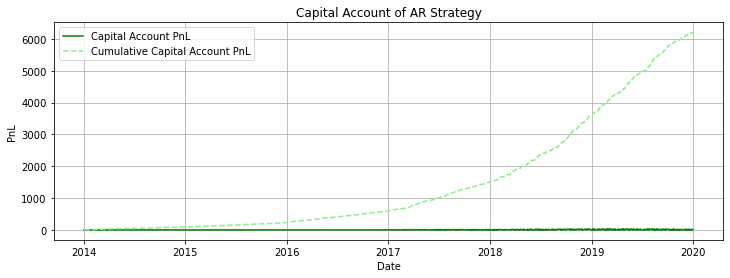

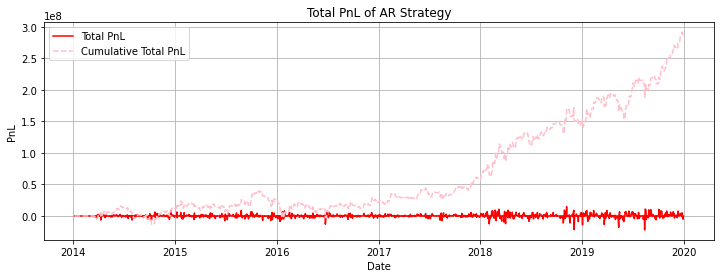

Performance Metrics of AR Strategy:
Dataset      Sharpe Ratio    Sortino Ratio    Max Drawdown    Max Drawdown Ratio    Calmar Ratio
---------  --------------  ---------------  --------------  --------------------  --------------
Train                7.94            76.16           10.97                  0.91            0.55
Test                 8.09            76.76            1.14                  0.91            0.57


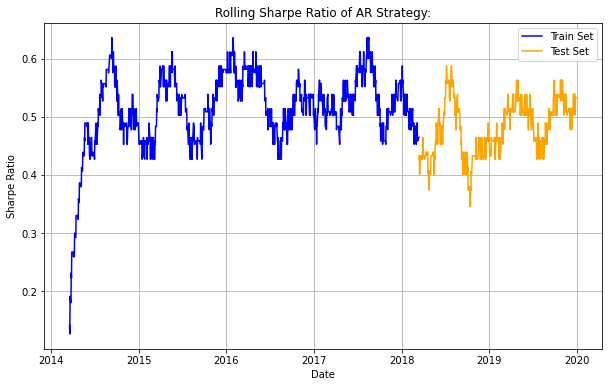

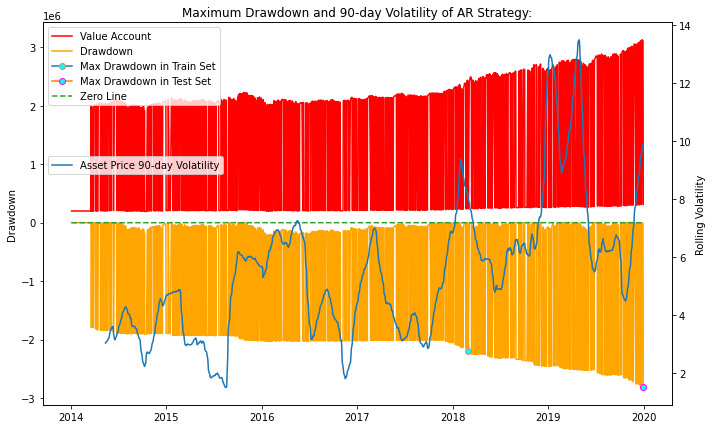

In [52]:
strategy_to_run = 'AR'
algo_trading.run(strategy_to_run)
